*First compiled: June 19, 2017.*

# Graph abstraction for minimal examples

In [1]:
import numpy as np
from matplotlib import rcParams
import matplotlib.pyplot as pl
import scanpy.api as sc
sc.settings.verbosity = 2                          # verbosity: 0=errors, 1=warnings, 2=info, 3=hints, ...
sc.settings.set_figure_params(dpi=80)              # dots (pixels) per inch determine size of inline figures
sc.logging.print_version_and_date()

Running Scanpy 0.3 on 2017-11-17 02:10.


The notebooks contains the following sections.
* Section 1: [Simulated data for myeloid progenitor development](#data1)  
* Section 3: [Simulated data for different degrees of clustering](#data2)

## Section 1: Simulated data for myeloid progenitor development <a id="data1"></a>

The simulated data describes development from a progenitor cell to four differentiated cell types: monocyte, erythrocyte, megakaryocyte and neutrophil.

See [Krumsiek *et al.* (2009)](https://doi.org/10.1371/journal.pone.0022649) for the definition of the boolean literature-curated network underlying the simulation and discussion of marker genes. The data has been generated using `sc.tl.sim('krumsiek11')`; see [here](https://github.com/theislab/scanpy_usage/tree/master/170430_krumsiek11) for more details. We add some clusters from a Gaussian mixture model to the data to model disconnected structure that might arise from imperfect sampling.

In [2]:
adata_krumsiek11 = sc.datasets.krumsiek11()
X_blobs = sc.datasets.blobs(cluster_std=0.5, n_centers=2).X
X_concatenated = np.r_[adata_krumsiek11.X, X_blobs]
adata = sc.AnnData(X_concatenated)
adata.var_names = adata_krumsiek11.var_names
adata.uns = adata_krumsiek11.uns
sc.write('krumsiek11_blobs', adata)

reading cache ./write/data/Users/alexwolf/hholtz/01_projects/1512_scanpy/scanpy/scanpy/datasets/krumsiek11.h5


Annotate the timeseries plot for Scanpy's simulation tool.

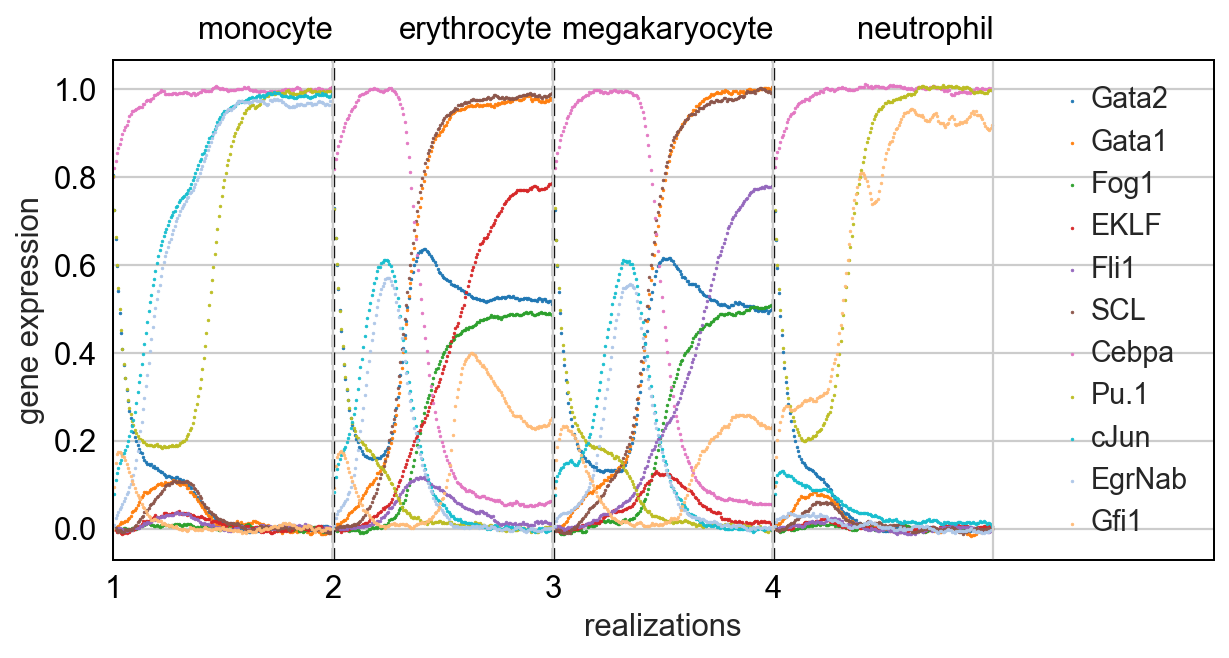

In [3]:
sc.pl.sim(adata_krumsiek11, tmax_realization=160, show=False)
xlim = pl.xlim()
pl.twiny()
pl.xlim(pl.xlim(xlim))
pl.xticks(np.arange(160, 5*160, 160),                                                                                                                           
          ['monocyte', 'erythrocyte', 'megakaryocyte', 'neutrophil'], ha='right')
pl.show()

Plot the same thing as heatmaps.

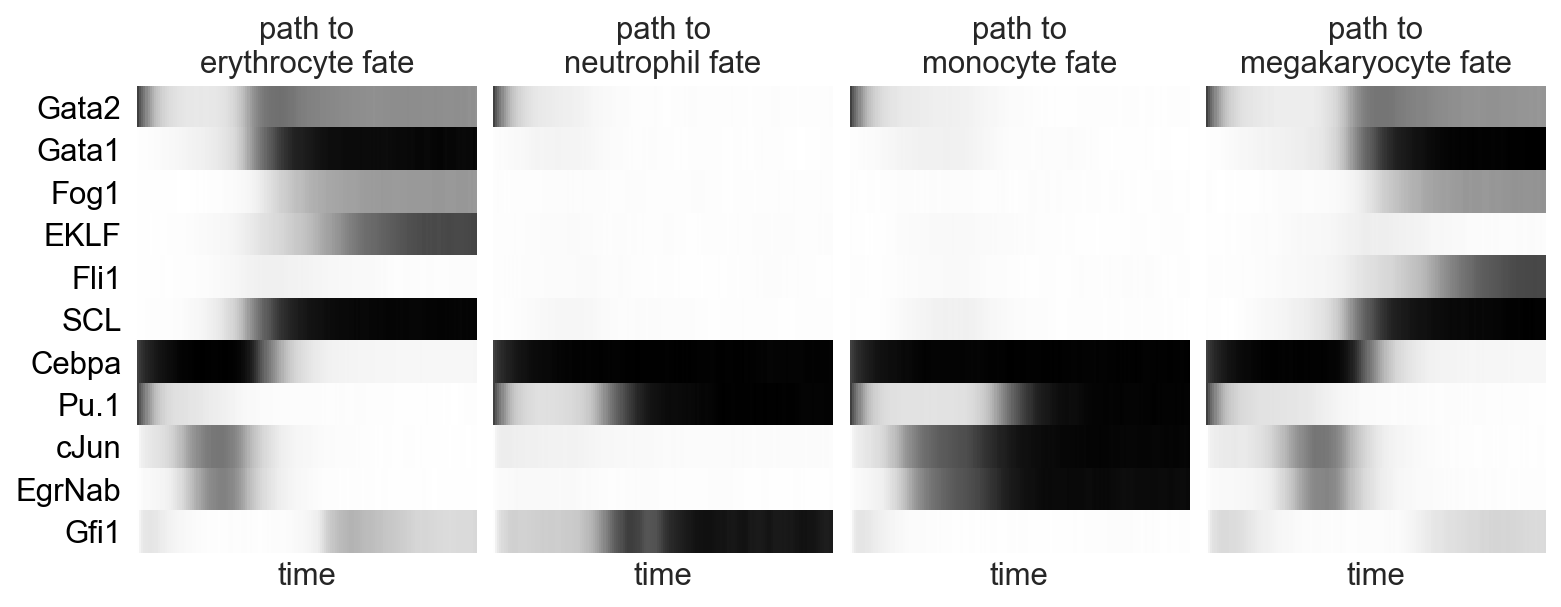

In [4]:
_, axs = pl.subplots(ncols=4, figsize=(10, 4), gridspec_kw={'wspace': 0.05, 'left': 0.1})
pl.subplots_adjust(left=0.05, right=0.98, top=0.88)
for ititle, (title, idcs) in enumerate([('erythrocyte', (160, 320)), ('neutrophil', (480, 640)), 
                                        ('monocyte', (0, 160)), ('megakaryocyte', (320, 480)), ]):
    pl.sca(axs[ititle])
    img = pl.imshow(adata.X[idcs[0]:idcs[1]].T, aspect='auto', interpolation='nearest')
    if ititle == 0: pl.yticks(range(adata.n_vars), adata.var_names)
    else: pl.yticks([])
    pl.title('path to\n{} fate'.format(title))
    pl.xticks([])
    pl.grid(False)
    pl.xlabel('time')
    axs[ititle].set_frame_on(False)
pl.savefig('./figures/krumsiek11_timeseries_heatmap.png', dpi=300)    
pl.show()

### Visualization

In [5]:
adata = sc.read('krumsiek11_blobs')
sc.tl.tsne(adata)
sc.tl.draw_graph(adata, random_state=5)  # random_state just makes a cosmetic change
sc.write('krumsiek11_blobs', adata)

computing tSNE
    using data matrix X directly (no PCA)
    using the "MulticoreTSNE" package by Ulyanov (2017)
    finished (0:00:04.478):  added
    "X_tsne", tSNE coordinates (adata.smp)
drawing single-cell graph using layout "fr"
    using data matrix X directly for building graph (no PCA)
    computing data graph with n_neighbors = 30 
    computing spectral decomposition ("diffmap") with 15 components
    eigenvalues of transition matrix
    [ 1.            1.            0.9999999404  0.998418808   0.996958375
      0.9920812249  0.9909048676  0.982462585   0.9651806951  0.9614251256
      0.9520589113  0.9385529757  0.9172902703  0.9089730382  0.8958995938]
    finished (0:00:19.509) and added
    "X_draw_graph_fr", graph_drawing coordinates (adata.smp)
    "draw_graph_params", the parameters (adata.uns)


... you are using a very low resolution for saving figures, adjusting to dpi=300
saving figure to file ./figures/tsne.png


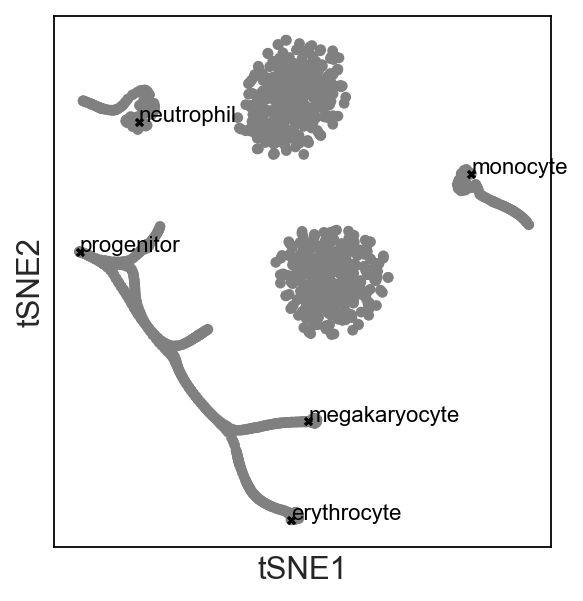

In [6]:
adata = sc.read('krumsiek11_blobs')
ax = sc.pl.tsne(adata, save=True)

saving figure to file ./figures/draw_graph_fr.png


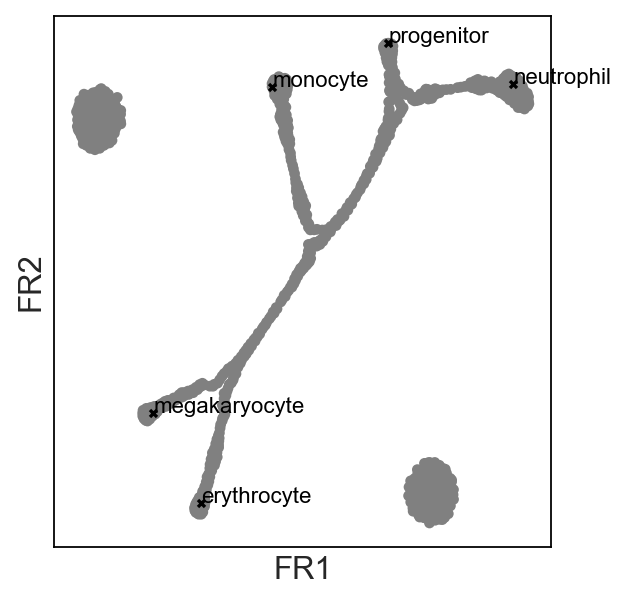

In [7]:
ax = sc.pl.draw_graph(adata, save=True)

## Construct the abstracted graph

In [8]:
adata = sc.read('krumsiek11_blobs')
sc.tl.aga(adata, resolution=2.5)
sc.write('krumsiek11_blobs', adata)

running Louvain clustering
    using data matrix X directly for building graph (no PCA)
    computing data graph with n_neighbors = 30 
    computing spectral decomposition ("diffmap") with 10 components
    eigenvalues of transition matrix
    [ 1.            1.            1.            0.9984188676  0.9969584346
      0.9920812249  0.9909048676  0.982462585   0.9651806951  0.9614251256]
    using the "louvain" package of Traag (2017)
    finished (0:00:01.358): found 13 clusters and added
    'louvain_groups', the cluster labels (adata.smp, dtype=category)
running Approximate Graph Abstraction (AGA)
    using data matrix X directly for building graph (no PCA)
    computing data graph with n_neighbors = 30 
    computing spectral decomposition ("diffmap") with 10 components
    eigenvalues of transition matrix
    [ 1.            1.            1.            0.9984188676  0.996958375
      0.9920812249  0.9909048676  0.9824625254  0.9651806951  0.9614251256]
    abstracted graph will h

In this case, the result is tree-like.

saving figure to file ./figures/aga.png


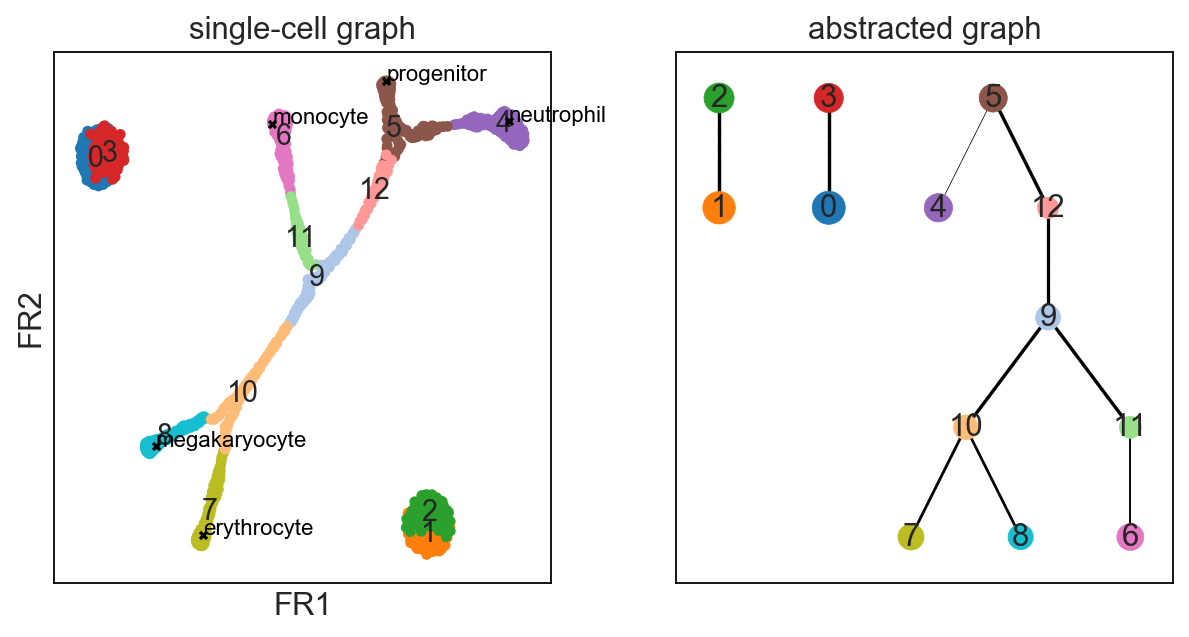

In [9]:
adata = sc.read('krumsiek11_blobs')
axs = sc.pl.aga(adata, basis='draw_graph_fr', right_margin=0.25,
                title='single-cell graph', save=True,
                root=[5, 3, 2], layout='rt',
                title_graph='abstracted graph')

You can also plot the distance along the manifold (pseudotime) - an extension of DPT [Haghverdi *et al.* (2016)](https://doi.org/10.1038/nmeth.3971).

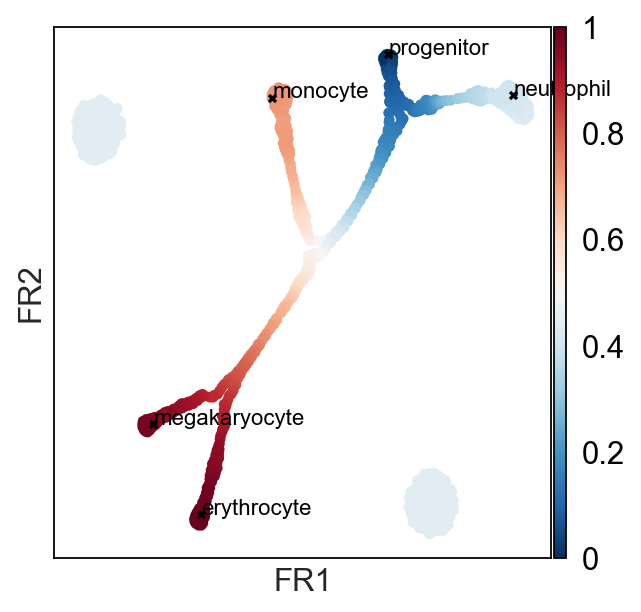

In [10]:
adata = sc.read('krumsiek11_blobs')
ax = sc.pl.draw_graph(adata, color='aga_pseudotime', title='', color_map='RdBu_r')

Save and export for external reusage.

In [11]:
sc.write('krumsiek11_blobs', adata)
sc.write('krumsiek11_blobs', adata, ext='csv')

writing csv files to ./write/krumsiek11_blobs/


### Gene changes along paths

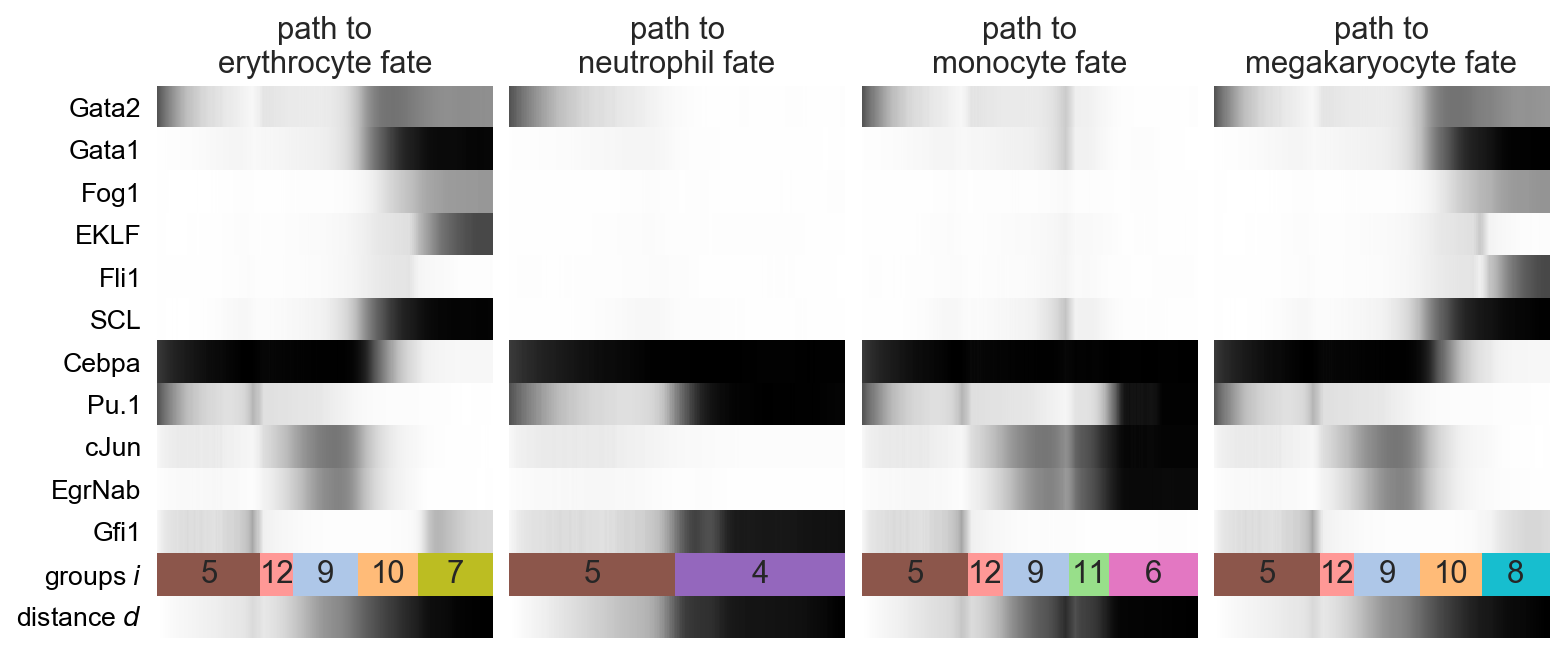

In [12]:
adata = sc.read('krumsiek11_blobs')
paths = [('erythrocytes', [5, 12, 9, 10, 7]),
         ('neutrophils', [5, 4]),
         ('monocytes', [5, 12, 9, 11, 6]),
         ('megakaryocytes', [5, 12, 9, 10, 8])]
_, axs = pl.subplots(ncols=4, figsize=(10, 4), gridspec_kw={'wspace': 0.05, 'left': 0.11})
pl.subplots_adjust(left=0.05, right=0.98, top=0.88)
for ipath, (descr, path) in enumerate(paths):
    sc.pl.aga_path(adata, left_margin=0.3, ytick_fontsize=12,
                   nodes=path, ax=axs[ipath],
                   keys=adata.var_names,
                   show_yticks=True if ipath==0 else False,
                   show_colorbar=False,                        
                   n_avg=10,
                   title='path to\n{} fate'.format(descr[:-1]),
                   show=False)
pl.savefig('./figures/aga_path.png', dpi=300)
pl.show()
sc.pl.reset_rcParams()

### Reclustering at higher resolution

Often, you would start with a low resolution to get an overview of your dataset.

In [2]:
sc.settings.verbosity = 1
adata = sc.read('krumsiek11_blobs')
sc.tl.louvain(adata, resolution=1.5)
sc.tl.aga(adata, groups='louvain_groups')

saving figure to file ./figures/aga_coarse.svg


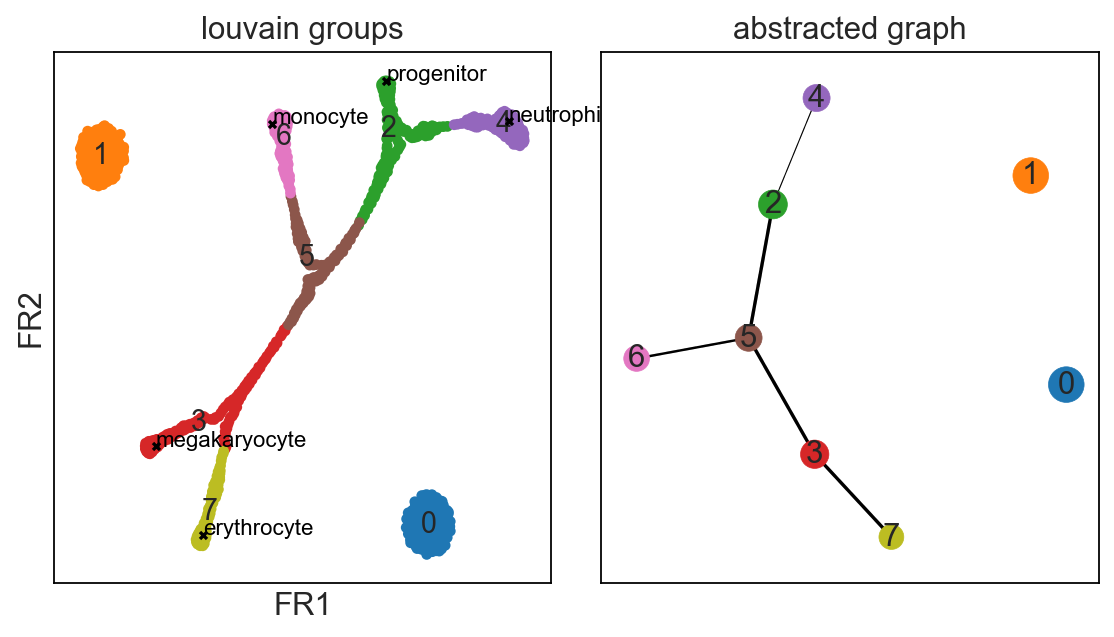

In [3]:
axs = sc.pl.aga(adata, basis='draw_graph_fr', save='_coarse', ext='svg')

To zoom into particular region, you can recluster the single-cell graph restricted to a subset. Here the louvain groups 2 and 3 to resolve the region around the progenitor in more detail.

In [4]:
sc.tl.louvain(adata, resolution=1.5, restrict_to=('louvain_groups', ['2', '3']))

saving figure to file ./figures/aga_coarse_R.svg


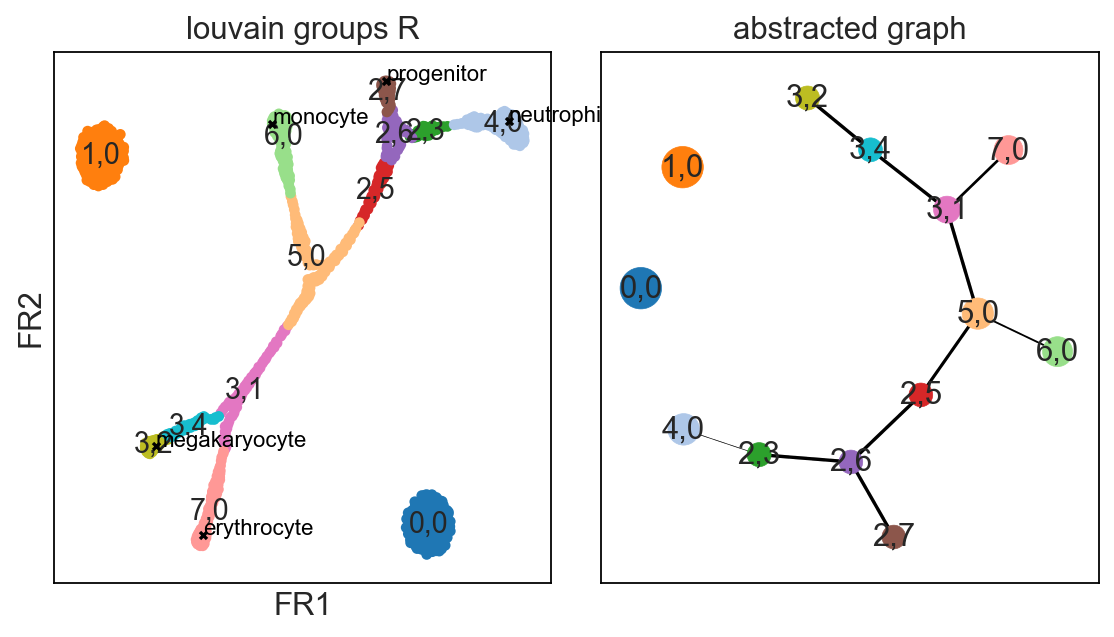

In [6]:
sc.tl.aga(adata, groups='louvain_groups_R')
axs = sc.pl.aga(adata, basis='draw_graph_fr', save='_coarse_R', ext='svg')

## Section 2: Simulated data for different degrees of clustering <a id="data2"></a>

saving figure to file ./figures/aga_cluster_std1.png


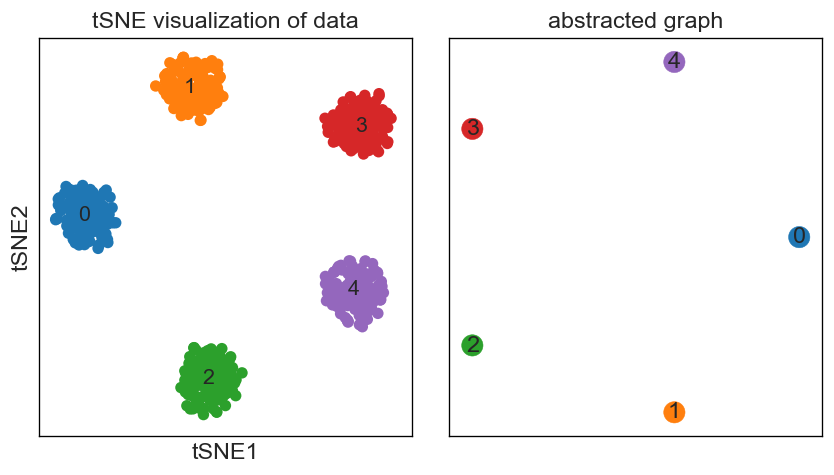

saving figure to file ./figures/aga_cluster_std6.png


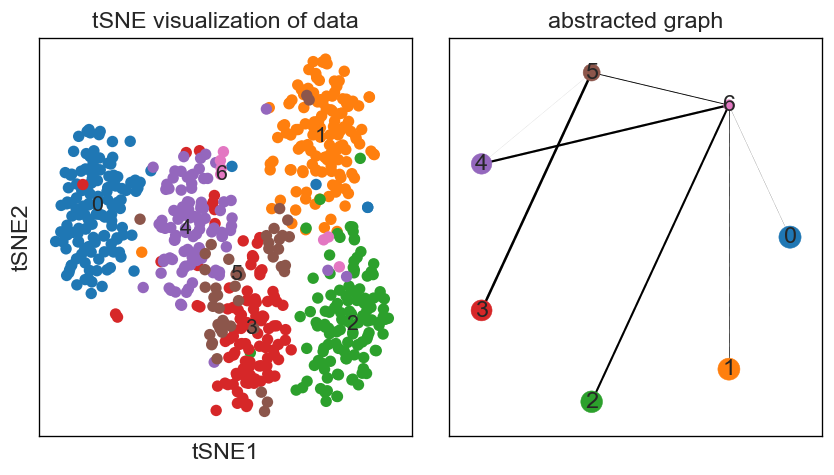

saving figure to file ./figures/aga_cluster_std10.png


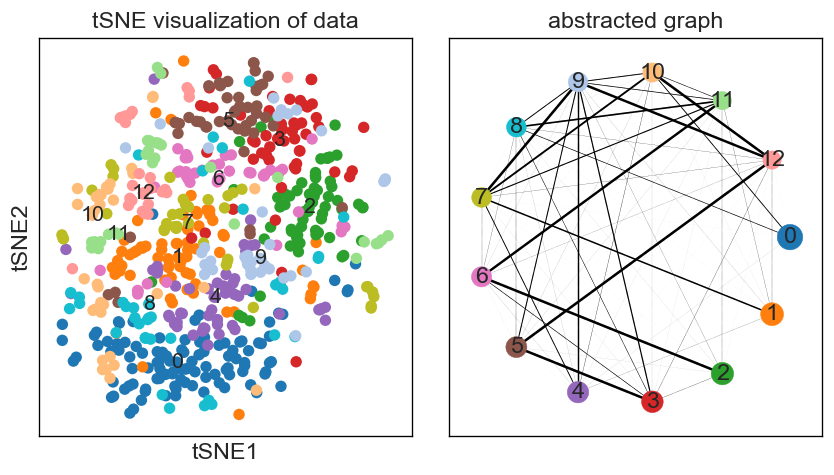

In [18]:
sc.settings.verbosity = 1
sc.settings.set_dpi(60)
for std in [1, 6, 10]:
    adata = sc.datasets.blobs(cluster_std=std, n_centers=5)
    sc.tl.tsne(adata)
    sc.tl.aga(adata, n_neighbors=5, tree_based_confidence=False)
    sc.pl.aga(adata,
              solid_edges='aga_adjacency_full_confidence',
              layout='circle',
              title='tSNE visualization of data',
              title_graph='abstracted graph',
              save='_cluster_std{}'.format(std),
              show=True, ext='svg')